In [ ]:
!pip install polars
!pip install gql
!pip install requests_toolbelt

In [ ]:
import polars as pl
import pandas as pd
import plotly.express as px
from pyspark.sql.functions import col, sum, year, month, split, when, size, expr, min, max, explode, get_json_object, expr, map_values, count, countDistinct
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType
from pyspark.sql.types import IntegerType
import os
# spark - This starts for me.


In [ ]:
dir_list = dbutils.fs.ls("dbfs:/data/idaho/patterns")

places = spark.read.parquet("dbfs:/data/idaho/places.parquet")
patterns = spark.read.parquet("dbfs:/data/idaho/patterns/part-00000-tid-2844737020712298775-f616784b-e90b-4e50-b792-759034c7ff46-1655-1-c000.snappy.parquet")

for item in dir_list:
    patterns = patterns.unionAll(spark.read.parquet(item.path))

# display(patterns)

In [ ]:
# Being filtered to 412 places when there are 1,213 congregations. That sounds fairly correct.
places_v1 = places.filter(col('location_name').rlike(' [L|l]atter |\b(?:[Ll]ds|LDS|latter|Latter|LATTER)\b'))

# I found a need to have placekey renamed later, Join the data
patterns_v05 = patterns.withColumnRenamed("placekey", "placekey_patterns")
df = patterns_v05.join(places_v1,places_v1.placekey ==  patterns_v05.placekey_patterns,"inner")

# Here I've pulled out all the data I think I'm going to need.
df_v1 = df.withColumn("Sunday_visits", df.popularity_by_day["Sunday"])\
                        .withColumn("Monday_visits", df.popularity_by_day["Monday"])\
                        .withColumn("Tuesday_visits", df.popularity_by_day["Tuesday"])\
                        .withColumn("Wednesday_visits", df.popularity_by_day["Wednesday"])\
                        .withColumn("Thursday_visits", df.popularity_by_day["Thursday"])\
                        .withColumn("Friday_visits", df.popularity_by_day["Friday"])\
                        .withColumn("Saturday_visits", df.popularity_by_day["Saturday"])\
                        .drop("popularity_by_day")\
                        .filter(col("Sunday_visits") > 0)\
                        .withColumn("timeInLocation_5_10", df.bucketed_dwell_times["5-10"])\
                        .withColumn("timeInLocation_21_60", df.bucketed_dwell_times["21-60"])\
                        .withColumn("timeInLocation_61_120", df.bucketed_dwell_times["61-120"])\
                        .withColumn("timeInLocation_0_4", df.bucketed_dwell_times["<5"])\
                        .withColumn("timeInLocation_240_999", df.bucketed_dwell_times[">240"])\
                        .withColumn("timeInLocation_11_20", df.bucketed_dwell_times["11-20"])\
                        .withColumn("timeInLocation_121_240", df.bucketed_dwell_times["121-240"])\
                        .drop("bucketed_dwell_times")\
                        .drop("related_same_day_brand", "related_same_month_brand")\
                        .withColumn("churchVisitTime",col("timeInLocation_21_60") + col("timeInLocation_61_120") + col("timeInLocation_121_240") + col("timeInLocation_240_999"))\
                        .withColumn("nonChurchVisitTime" , col("timeInLocation_0_4") + col("timeInLocation_5_10") + col("timeInLocation_11_20"))\
                        .withColumn("start_year", year("date_range_start"))\
                        .withColumn("start_month", month("date_range_start"))\
                        .withColumn("end_year", year("date_range_end"))\
                        .withColumn("end_month", month("date_range_end"))\
                        .filter(col("Sunday_visits") > 5)\
                        .withColumn("device_sampling_rate", col("normalized_visits_by_state_scaling") / col("raw_visit_counts"))

# Now I'm doing the Calculations
df_v2 = df_v1.withColumn("Sunday_visits_actual", col("normalized_visits_by_state_scaling") * col("Sunday_visits") / col("raw_visit_counts"))\
             .withColumn("churchVisitTime_ratio", col("churchVisitTime") / col("raw_visit_counts"))\
             .withColumn("Sunday_visits_actual_v2", col("Sunday_visits_actual") * col("churchVisitTime_ratio"))\
             .withColumn("Sunday_members", col("Sunday_visits_actual_v2") / 4.345)\
             .withColumn("values", map_values(col("visitor_home_aggregation")))\
             .withColumn("tractTotals", expr("aggregate(values, 0, (acc, x) -> acc + x)"))\
             .select("*", explode(col("visitor_home_aggregation")).alias("tract_num", "tract_visitors"))\
             .withColumn("tract_members", col("Sunday_members") * col("tract_visitors")/col("tractTotals"))\
             .groupBy('placekey', 'tract_num')\
             .agg(sum("tract_members").alias("tract_members_v2"), count("*").alias("church_patterns_count"))\
             .withColumn("tract_members_v3", col("tract_members_v2") / col("church_patterns_count"))\
             .groupBy('tract_num')\
             .agg(sum("tract_members_v3").alias("final_tract_members")).alias("tract_members_actual")\
             .filter(col("tract_num").like("16%"))                                                      # filtered for idaho tracts

display(df_v2)
display(df_v2.count())



tract_num,final_tract_members
16029960100,712.0830816967118
16031950100,320.7552201986086
16027021700,190.73808225865196
16055000500,40.024733480255875
16031950300,527.5583441744711
16067970400,294.15670422408357
16027021002,323.1554155094899
16027021500,173.28975525422098
16069960700,11.910476646643975
16001002224,421.8699849635324


286

In [ ]:
tracts_data = spark.read.parquet("dbfs:/data/idaho/tract_table.parquet")

tract_final_calculations = df_v2.join(tracts_data,tracts_data.tractcode ==  df_v2.tract_num,"inner")

display(tract_final_calculations)
display(tract_final_calculations.count())

tract_num,final_tract_members,state,county,tract,tractcode,name,land_m,water_m,lat,long,cnamelong,tractname,city,county_name,city_population_2010,city_long,city_lat,stusab,state_name,statens
16029960100,712.0830816967118,16,029,960100,16029960100,9601,1.63197566E9,1.3413969E7,42.6943684,-111.8511424,Caribou County,9601,Soda Springs,Caribou,3058,-111.586082,42.6578731,ID,Idaho,01779783
16031950100,320.7552201986086,16,031,950100,16031950100,9501,4.213342353E9,2.4740145E7,42.290077,-113.3791677,Cassia County,9501,Burley,Cassia,10345,-113.7935999,42.5374311,ID,Idaho,01779783
16027021700,190.73808225865196,16,027,021700,16027021700,217,8725667.0,0.0,43.6405726,-116.6793138,Canyon County,217,Caldwell,Canyon,46237,-116.6593359,43.6458804,ID,Idaho,01779783
16055000500,40.024733480255875,16,055,000500,16055000500,5,1.4555755E7,0.0,47.7287605,-116.9210756,Kootenai County,5,Post Falls,Kootenai,27574,-116.9388031,47.7201843,ID,Idaho,01779783
16031950300,527.5583441744711,16,031,950300,16031950300,9503,5.498484E7,707331.0,42.4805097,-113.7526916,Cassia County,9503,Burley,Cassia,10345,-113.7935999,42.5374311,ID,Idaho,01779783
16067970400,294.15670422408357,16,067,970400,16067970400,9704,2.003662E7,25585.0,42.6141552,-113.6997879,Minidoka County,9704,Rupert,Minidoka,5554,-113.6739561,42.6189471,ID,Idaho,01779783
16027021002,323.1554155094899,16,027,021002,16027021002,210.02,2.0724482E7,54940.0,43.6152472,-116.6078682,Canyon County,210.02,Caldwell,Canyon,46237,-116.6593359,43.6458804,ID,Idaho,01779783
16027021500,173.28975525422098,16,027,021500,16027021500,215,3053888.0,1386.0,43.6581278,-116.684917,Canyon County,215,Caldwell,Canyon,46237,-116.6593359,43.6458804,ID,Idaho,01779783
16069960700,11.910476646643975,16,069,960700,16069960700,9607,7.70044616E8,9388302.0,46.0956517,-116.8989005,Nez Perce County,9607,Lewiston,Nez Perce,31894,-116.9934717,46.3931296,ID,Idaho,01779783
16001002224,421.8699849635324,16,001,002224,16001002224,22.24,7352237.0,8632.0,43.5857812,-116.2955596,Ada County,22.24,Boise,Ada,205671,-116.2310843,43.5984881,ID,Idaho,01779783


286

In [ ]:
!pip install geopandas
!pip install geodatasets

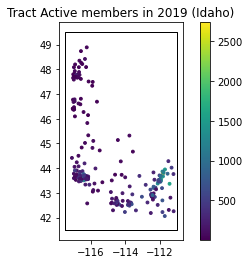

In [ ]:
import matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from geodatasets import get_path

tract_final_pandas = tract_final_calculations.toPandas()

# idaho_bbox = (-116.916073, 41.987144, -111.043564, 49.001494)  # (minx, miny, maxx, maxy)


gdf = geopandas.GeoDataFrame(
    tract_final_pandas, geometry=geopandas.points_from_xy(tract_final_pandas.long, tract_final_pandas.lat), crs="EPSG:4326"
)

world = geopandas.read_file(get_path("naturalearth.land"))

# We restrict to Idaho
ax = world.clip([-117.5, 41.5, -111, 49.5]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='final_tract_members', markersize=8, legend=True, aspect='auto').set_title('Tract Active members in 2019 (Idaho)')

plt.show()